# Exploratory data analysis using Kallisto data
transcripts per million output was obtained from cluster

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

###Looking at a single file

In [2]:
Fr188_C1=pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/Fr188_C1_TTAGGC/abundance.tsv",sep="\t")


In [3]:
Fr188_C1.head()

,target_id,length,eff_length,est_counts,tpm
0,FBtr0071764,5173,4974,33.8472,0.504464
1,FBtr0100521,4665,4466,179.1580,2.973920
2,FBtr0071763,4847,4648,142.0220,2.265180
3,FBtr0342981,3897,3698,36.9729,0.741191
4,FBtr0083388,3935,3736,103.4280,2.052320


Checking that tpm sum up to 1000000

In [4]:
sum(Fr188_C1.tpm) , len(Fr188_C1)

(999999.92981562519, 30446)

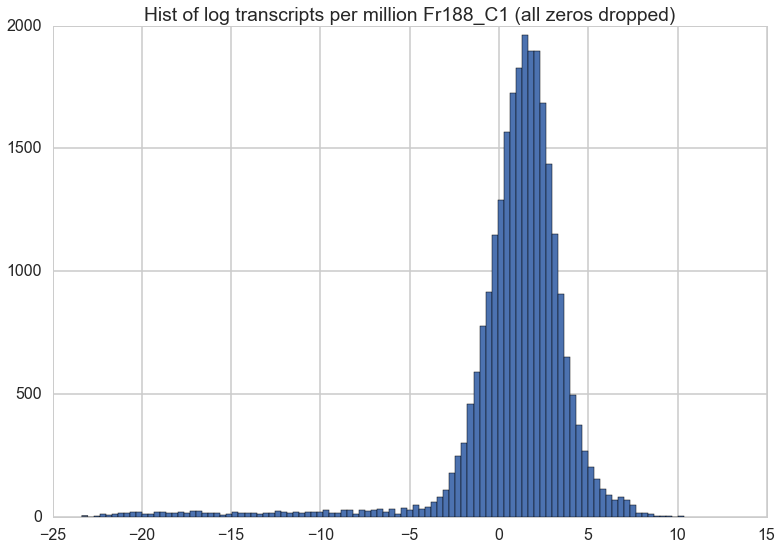

In [5]:
plt.hist(np.log(Fr188_C1[Fr188_C1.tpm>0].tpm), bins=100)
plt.title("Hist of log transcripts per million Fr188_C1 (all zeros dropped)")
plt.show()

#Looking at the output of all Kallisto files

In [6]:
#Create a dataframe with tpm data from all files
import glob
import string
files_dict={}
for fl in glob.glob("../KallistoFiles/*"):
    a= string.join(fl.split('/')[2].split('_')[:2], sep="_")
    if a:
        files_dict[a]=pd.read_csv(fl+"/abundance.tsv", sep="\t").tpm

LoadedData=pd.DataFrame(files_dict)

In [7]:
LoadedData.head()

,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5,Zi238_C1,Zi238_C2,Zi238_C3,Zi238_C4,Zi238_T2,Zi238_T3,Zi238_T4,Zi257_C1,Zi257_C2,Zi257_C3,Zi257_T1,Zi257_T2,Zi257_T3,Zi257_T4
0,0.504464,1.284890,0.614044,0.00000,0.000000,0.000000,0.440369,0.691164,0.262204,0.000000,0.147861,0.00000,0.440267,0.652083,0.894199,0,1.548400e-01,0.000000,0.133242,0.00000,0.57178,0.37936,0.000000,0.105309,0.00000,0.00000
1,2.973920,4.151500,5.322480,3.70415,5.352650,3.635080,10.496100,8.771190,1.165150,4.027210,3.819260,5.20589,4.586930,5.192110,1.115020,0,4.127860e+00,3.603360,4.166850,5.08526,8.40361,6.08674,5.779740,4.997630,3.46231,5.69248
2,2.265180,1.434560,0.000000,0.00000,0.000000,0.461069,1.724620,0.563522,5.122970,0.000000,0.000000,0.00000,2.278640,1.485840,5.823160,0,0.000000e+00,0.000000,0.351757,5.27287,0.00000,4.23550,0.413694,0.000000,0.32999,0.00000
3,0.741191,0.350953,0.000484,0.00000,0.445147,0.000000,0.923483,0.000000,1.166280,0.158618,0.428323,0.00000,0.429408,0.000000,0.000000,0,1.491710e-07,0.411839,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000
4,2.052320,0.690347,1.806490,3.43484,4.507330,4.265000,2.172480,0.869259,1.108070,3.678080,3.580640,3.87075,2.379780,2.346690,3.902570,0,4.123990e+00,5.012800,4.700970,1.88296,2.12189,2.37721,4.582620,3.783650,4.41964,2.67030


###Do a PCA

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = pca.fit_transform(LoadedData.transpose())

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [9]:
print pca.explained_variance_ratio_.sum()

1.0


In [10]:
pca.explained_variance_ratio_*100

array([  7.52801689e+01,   1.72597998e+01,   4.90974923e+00,
         9.45304187e-01,   5.52002110e-01,   3.54150269e-01,
         2.72988302e-01,   9.53703335e-02,   8.94500230e-02,
         6.78247285e-02,   3.69397135e-02,   2.37528529e-02,
         2.27045440e-02,   1.64706681e-02,   1.36633287e-02,
         1.27654231e-02,   1.17467993e-02,   7.89890982e-03,
         6.32380373e-03,   5.42984463e-03,   4.41862789e-03,
         3.87113957e-03,   3.32985515e-03,   2.57134247e-03,
         1.30524287e-03,   1.03545849e-28])

The variance is really explained here by the first two components

In [11]:
#Labeling with either a C or T
TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in LoadedData.columns]
countryLabels=[a[:2] for a in LoadedData.columns]
dfPCA = pd.DataFrame({"TorC":TorClabels, "lines":lineLabels, "country":countryLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfPCA["pc%i" % (i+1)] = X[:,i]
dfPCA


,TorC,country,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26
0,C,Fr,188,-77861.212494,-20579.532686,189.496710,-20533.003250,167.058036,-1471.608864,5322.687246,-784.681769,2085.963593,-3789.205860,2922.461683,-499.323103,-1796.480254,1020.716837,1630.082631,2405.584889,1340.180561,-329.985166,-373.460795,-335.212381,-157.912675,-12.357166,-64.871539,-51.442106,-41.954812,-9.635260e-11
1,C,Fr,188,-79481.413308,-19918.021405,2440.643167,-6389.973790,1330.481159,574.600991,-3268.615543,89.951099,-2724.114930,1484.747413,-2518.907157,-81.511894,1407.733065,1660.070632,-690.114787,-865.539749,1944.767066,-565.993597,-1443.132395,734.682713,-287.727586,315.623118,-1224.162393,-567.792649,-2.082639,-9.635260e-11
2,C,Fr,188,-77842.080732,-15803.318013,-1966.579994,16735.661162,-2738.120782,-1175.183780,-3210.845955,242.083614,-1916.295274,-4847.769238,-1478.543633,743.738225,1131.632639,2829.512050,295.057571,513.756239,745.900457,21.548802,1100.687861,815.907370,478.223358,-431.472921,647.329424,629.091470,129.376831,-9.635260e-11
3,T,Fr,188,58623.691167,1323.325916,-95951.630416,1825.564434,6253.525368,3712.598062,2516.612804,1286.962613,-965.881743,111.698729,368.954757,755.340925,-451.598481,68.494108,542.504185,-398.777641,-52.131248,123.001964,-42.662084,33.658323,213.808730,379.013543,-90.882021,-54.618358,202.298238,-9.635260e-11
4,T,Fr,188,78462.061972,1756.560923,8353.103837,1913.075529,4074.178346,3287.373496,1000.186467,-1876.912076,1981.438476,-455.455201,-1223.743537,-1303.198620,1877.768617,-1296.193727,-1091.550489,2108.431432,497.586018,484.493742,335.146357,170.181669,893.477856,1638.028593,-420.379213,622.492252,-219.950251,-9.635260e-11
5,T,Fr,188,95112.715682,3632.929481,-2121.465440,-4571.491014,-11027.603812,-2904.803051,-3979.437264,-9087.474587,1818.110652,309.764479,-1495.565242,3684.575386,-955.415513,-387.426786,70.513698,-264.721055,130.075871,-1158.812477,7.174275,-280.583199,151.435437,73.645961,66.121928,73.224859,101.421597,-9.635260e-11
6,C,Fr,89,-72345.467140,-16925.120707,3217.270937,9490.509301,1646.655305,1250.269822,-5518.279509,297.982348,2567.242834,218.081256,1414.728710,395.049781,118.270486,-573.773250,447.105118,173.042277,-1071.307518,-262.608885,-1868.791253,989.600574,-842.900189,938.460884,1324.974939,-65.214445,-97.110113,-9.635260e-11
7,C,Fr,89,-86973.347389,-21397.427009,-484.812748,-11128.064743,1002.648957,310.605147,-1865.644535,743.894318,-1775.586352,5101.087377,-1159.844221,-420.165716,-1147.854172,245.013433,219.027247,1468.665715,-2615.669605,-995.588954,1204.134363,1226.631444,55.203821,-169.638770,-335.552523,143.145814,46.536877,-9.635260e-11
8,C,Fr,89,-83529.546423,-16705.344734,-1588.784673,10241.953603,-7480.291301,-3503.980229,16873.176589,-762.925741,5960.603264,3206.728239,19.232196,295.801061,1092.179940,821.371100,-721.792412,-563.010415,-254.363462,225.107408,39.442693,156.019117,303.752169,-219.778943,35.961859,-383.462027,-159.723444,-9.635260e-11
9,T,Fr,89,85310.553746,3043.187831,7733.378549,-2969.006163,-8318.719777,-1998.819669,1530.736022,6856.432170,-3756.086346,206.625405,2559.642009,2813.041550,-1250.469310,402.667466,-2287.597243,88.352929,194.199823,-185.517505,-96.921507,7.588956,5.164091,249.612211,9.982929,353.484652,-604.129539,-9.635260e-11


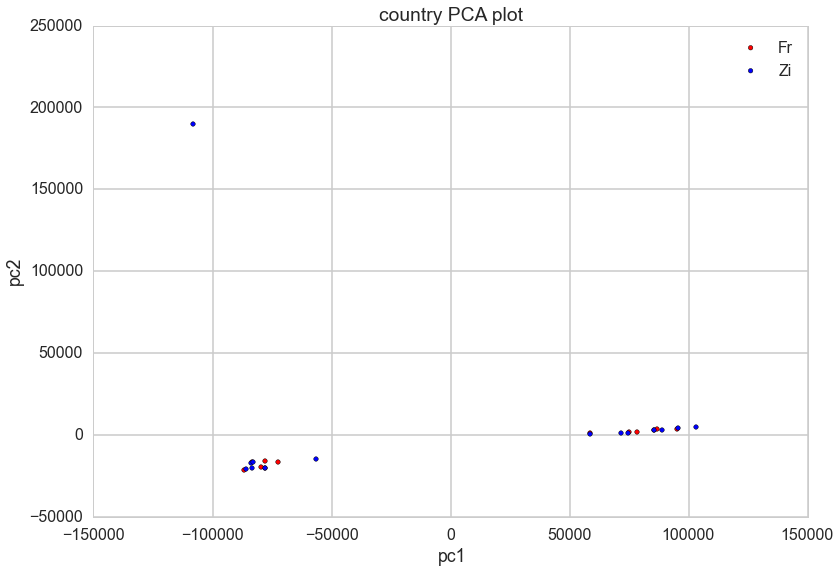

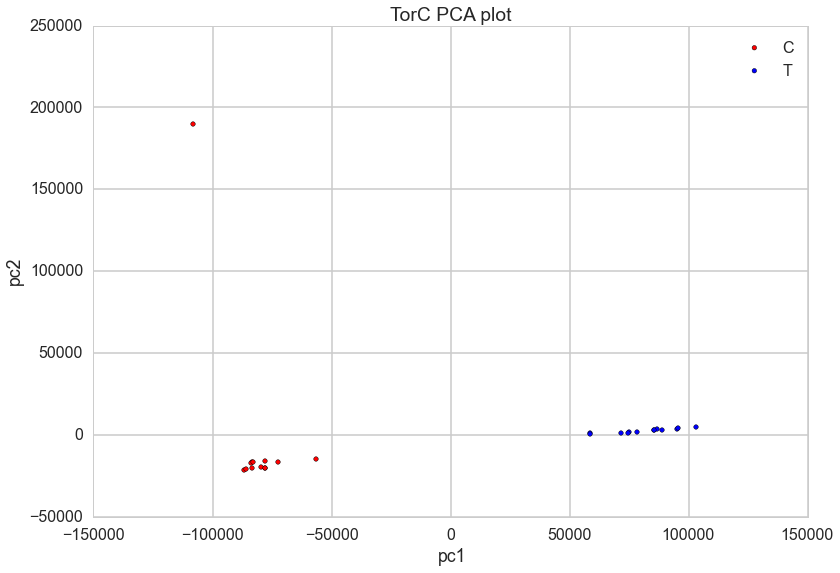

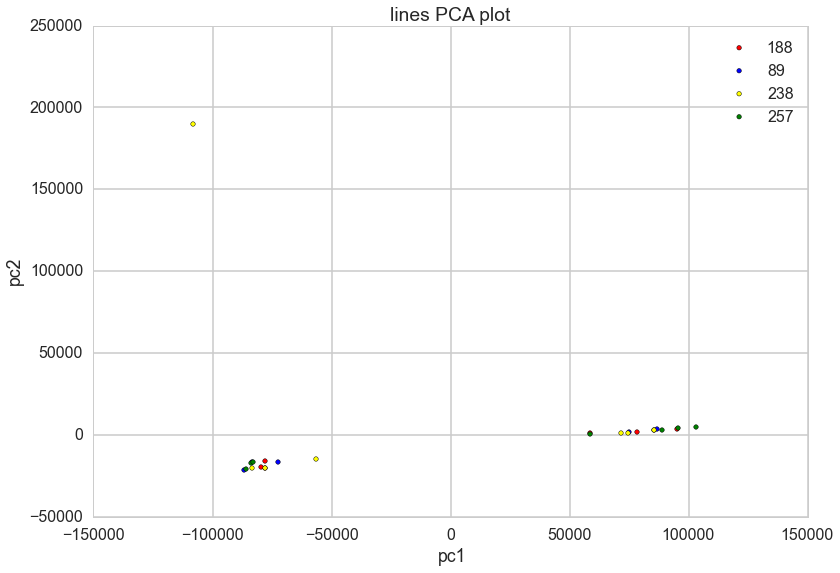

In [13]:
def plot_PCA(labelName, df, firstComponent="pc1", secondComponent="pc2"):
    plt.figure()
    colors=["red","blue","yellow", "green"]
    for label, color in zip(df[labelName].unique(), colors):
        mask = df[labelName]==label
        plt.scatter(df[mask][firstComponent], df[mask][secondComponent], c=color, label=label)
    plt.legend()
    plt.title(labelName +" PCA plot")
    plt.xlabel(firstComponent)
    plt.ylabel(secondComponent)
    plt.show()

plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Carcass points cluster together.  Lines do not cluster together.  One strain of zimbabwe carcass 238 sticks out.

##Removing weird Zi238_C4  (and also Fr188_T3 because that then showed up as an outlier)

In [14]:
del LoadedData["Zi238_C4"]
del LoadedData["Fr188_T3"] 
print LoadedData.columns
pca = PCA(n_components=50)
X = pca.fit_transform(LoadedData.transpose())
pca.explained_variance_ratio_*100

Index([u'Fr188_C1', u'Fr188_C2', u'Fr188_C3', u'Fr188_T5', u'Fr188_T6', u'Fr89_C1', u'Fr89_C2', u'Fr89_C4', u'Fr89_T3', u'Fr89_T4', u'Fr89_T5', u'Zi238_C1', u'Zi238_C2', u'Zi238_C3', u'Zi238_T2', u'Zi238_T3', u'Zi238_T4', u'Zi257_C1', u'Zi257_C2', u'Zi257_C3', u'Zi257_T1', u'Zi257_T2', u'Zi257_T3', u'Zi257_T4'], dtype='object')


array([  9.55598436e+01,   1.39003128e+00,   1.22922896e+00,
         5.98588225e-01,   4.14025073e-01,   2.64173386e-01,
         1.25635313e-01,   1.03706528e-01,   9.26307061e-02,
         4.95548686e-02,   3.14791172e-02,   2.70593735e-02,
         2.26876882e-02,   1.79350275e-02,   1.62479180e-02,
         1.34034501e-02,   1.06414635e-02,   8.61505971e-03,
         7.49915296e-03,   5.87843840e-03,   4.59324222e-03,
         3.60015266e-03,   2.94200828e-03,   1.20493508e-29])

In [16]:
#Labeling with either a C or T
TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in LoadedData.columns]
countryLabels=[a[:2] for a in LoadedData.columns]
dfPCA = pd.DataFrame({"TorC":TorClabels, "lines":lineLabels, "country":countryLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfPCA["pc%i" % (i+1)] = X[:,i]
dfPCA


,TorC,country,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24
0,C,Fr,188,-80942.317118,-15213.825438,14079.137450,-741.076630,5024.513118,2671.520764,-947.896752,-1391.192972,4023.142165,2739.570086,-1715.344136,-739.340971,-953.922204,-3039.085615,-1161.717145,149.961891,-264.244228,385.091157,-348.480328,139.936790,-74.526924,46.659079,-35.019318,-2.927825e-11
1,C,Fr,188,-82401.457137,-3630.373183,5756.006086,582.560240,-2605.232146,-2464.168320,1905.860329,1511.706452,-1709.319983,-2385.913937,1025.533658,1147.789800,-1510.035849,999.630309,-2096.836292,537.885714,-837.248634,1359.942463,697.661688,476.858083,-1146.082368,387.764874,-380.062630,-2.927825e-11
2,C,Fr,188,-80418.875802,9014.017682,-14924.241366,1065.394919,-2012.898506,-1606.152693,1100.437314,2344.650524,4569.671692,-1401.517552,1359.907838,267.078492,-2767.330732,-737.988748,-809.845425,-116.258462,82.785186,-1095.635148,816.480563,-662.463710,557.753393,-466.603924,477.091512,-2.927825e-11
3,T,Fr,188,77106.204187,4295.248319,1965.205267,837.415121,-2307.681313,4449.443794,-326.879017,-956.458081,450.228455,-869.238704,732.190242,1244.236918,1336.746161,-686.424806,-179.863247,3202.693157,-398.395490,-548.505861,-36.839258,-9.131359,40.089330,-1021.486117,-674.865437,-2.927825e-11
4,T,Fr,188,93539.597836,-13060.039084,-7632.423679,-2516.578640,-912.081628,-1361.657621,5373.959783,-7786.315596,791.869374,-2390.004193,1347.030248,-2323.912681,290.682748,59.728215,-181.643481,-664.858310,-1035.239266,-21.331043,-333.492245,-92.313669,82.166286,-66.078469,87.681715,-2.927825e-11
5,C,Fr,89,-74936.151957,8147.788962,-5047.160834,1633.042399,-5184.319206,-2255.184104,-1881.487583,-2215.597543,101.556403,1197.911395,296.018230,20.995534,603.772802,-330.185167,1058.336141,-50.256132,-415.684263,1828.429296,1031.417433,1067.949203,1470.953667,12.836639,-175.467668,-2.927825e-11
6,C,Fr,89,-90112.425345,-8651.990758,7542.256405,692.006870,-1654.327436,-1148.606156,734.260400,1080.547673,-5306.662560,-996.206568,-1114.958235,-639.227413,-382.182794,-1143.688259,2705.341946,-37.963770,-1047.751063,-1250.932132,1190.871920,-99.050295,-370.068628,-126.799316,118.721075,-2.927825e-11
7,C,Fr,89,-86153.658361,4309.292057,-10924.431705,-5315.242485,15066.370981,9173.560399,-3897.402140,-3522.826729,-2897.150921,88.475631,1076.286320,278.844705,-848.448509,886.059403,179.586483,57.902013,192.225661,-37.863590,184.296557,-379.480371,4.339456,354.874379,-228.357536,-2.927825e-11
8,T,Fr,89,84067.041652,-3721.648207,-623.233410,-6030.124695,4830.748353,-5734.234400,-1961.143236,5162.743059,-774.809029,2442.939593,873.058573,-3844.564348,-795.174411,1184.806571,-168.806043,205.373526,-142.347803,107.441023,12.433304,42.572770,131.151099,-538.930151,-609.892757,-2.927825e-11
9,T,Fr,89,84888.602289,-11099.100513,-9873.030730,3807.235225,-5097.990340,8110.342840,-1574.737751,2003.134529,-116.019881,1206.848804,-1956.878410,1759.077950,-971.423682,1262.748747,64.075452,-1637.404098,-1352.072965,241.418150,-558.702437,309.761928,-48.538109,-767.110276,71.397482,-2.927825e-11


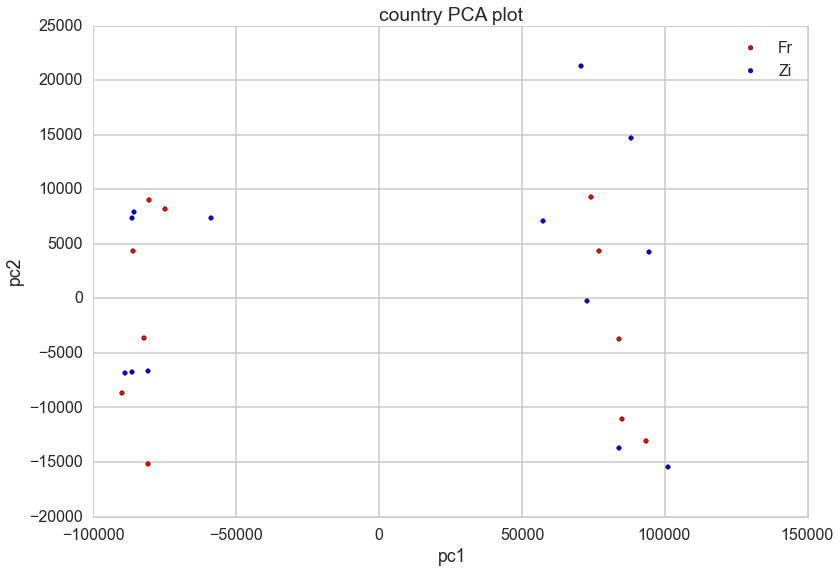

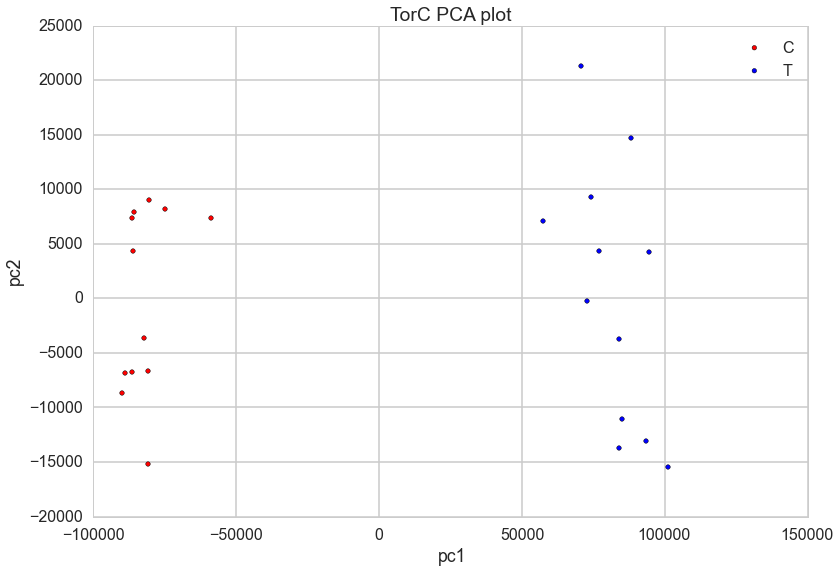

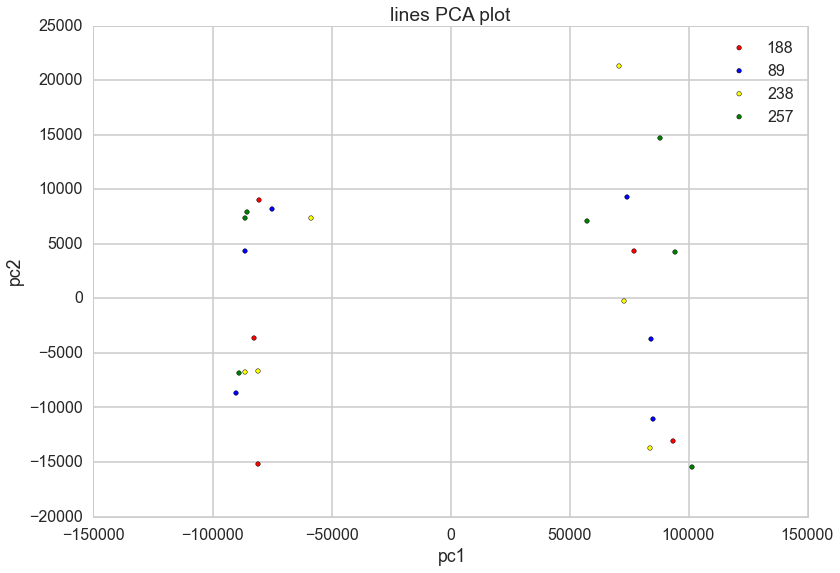

In [17]:
plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Plotting 2nd and 3rd components

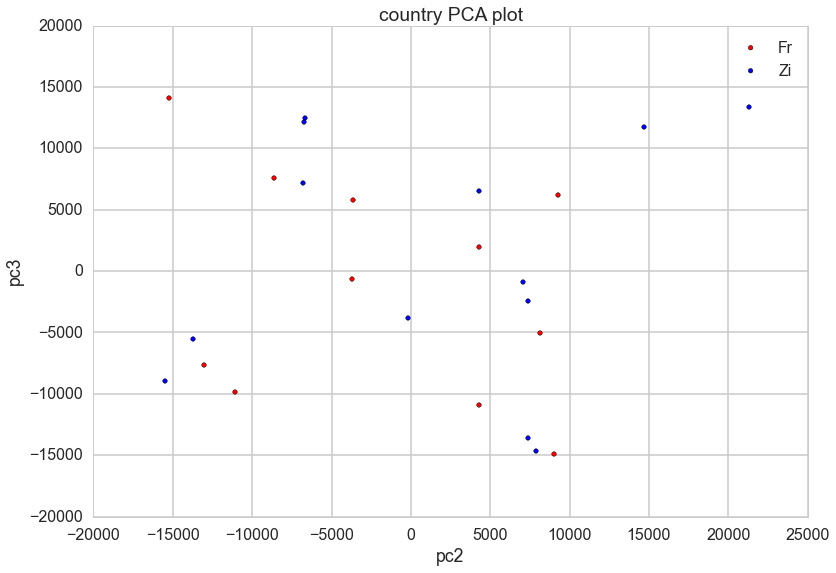

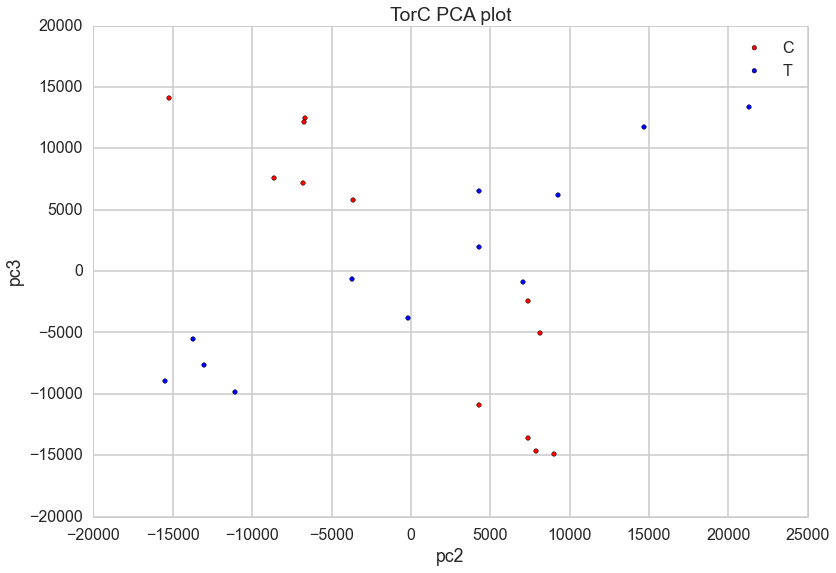

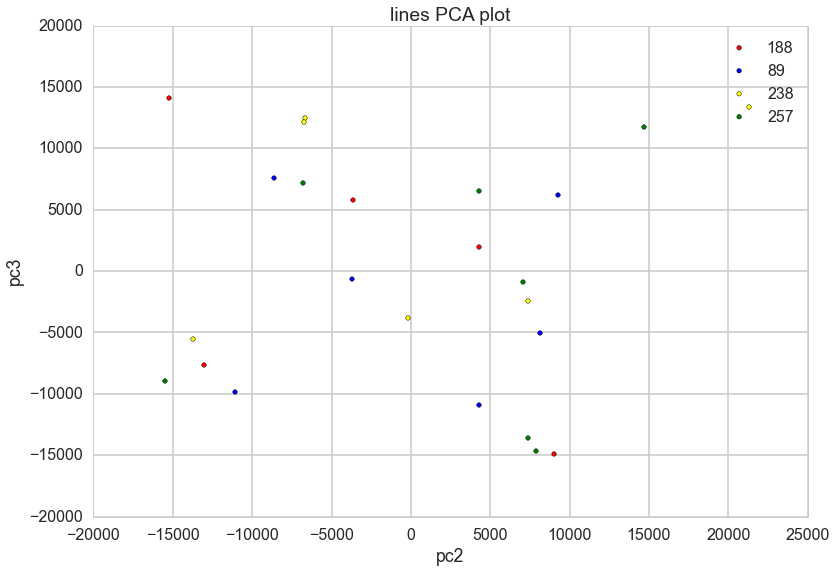

In [18]:
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("TorC", dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")

##Let's now consider carcass only data

In [19]:
TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
dfCarcass=LoadedData[[col for lab,col in zip(TorClabels,LoadedData.columns) if lab=="C"]]
pca = PCA(n_components=10)
X = pca.fit_transform(dfCarcass.transpose())
pca.explained_variance_ratio_*100

array([ 54.26504597,  27.11773948,   9.48378325,   3.96034442,
         1.78182626,   1.19914835,   0.79829824,   0.43437374,
         0.37312756,   0.34193487])

In [20]:
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in dfCarcass.columns]
countryLabels=[a[:2] for a in dfCarcass.columns]
dfCarcassPCA = pd.DataFrame({"lines":lineLabels, "country":countryLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfCarcassPCA["pc%i" % (i+1)] = X[:,i]
dfCarcassPCA

,country,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,Fr,188,-19961.270826,729.418189,-7972.705127,-3349.057763,-5242.463301,-827.064287,542.272288,-708.503184,757.456859,-513.874482
1,Fr,188,-6646.463590,2251.263367,3912.701502,1085.319224,877.308276,-2872.229523,-2784.664052,-2104.128510,-477.289597,1341.062862
2,Fr,188,17293.217904,-983.881162,3109.842446,-5300.553925,-78.199967,-3713.573240,411.370437,1540.707307,993.130801,482.357960
3,Fr,89,10363.476936,8112.631205,529.536977,770.714947,1867.395802,2029.111380,1531.362469,-1238.332415,2515.646474,430.397121
4,Fr,89,-12575.473255,-4342.447737,5813.385603,4672.194453,-1383.995021,-19.136040,3173.659958,767.954280,-768.738319,1608.912766
5,Fr,89,9679.833341,-15891.045576,-13189.351385,3778.687901,2347.567902,-743.732833,68.562432,4.248952,-234.120703,212.062626
6,Zi,238,11258.677012,24141.257754,-5744.038446,1162.387713,-789.070816,925.817093,-430.877773,777.202050,-1459.938435,415.180298
7,Zi,238,-13414.390750,6453.538944,3017.664240,4445.368546,2394.193419,-1989.875270,199.626033,529.062854,322.109762,-2507.797018
8,Zi,238,-14558.613301,-1603.753685,-45.543371,-7515.969589,4232.841394,1866.049338,919.408995,-420.585334,-1158.268466,-28.994542
9,Zi,257,14263.514625,-6675.988264,5023.987383,1174.541077,-2454.174535,2077.661773,-394.012864,-1596.404831,-303.226369,-849.781269


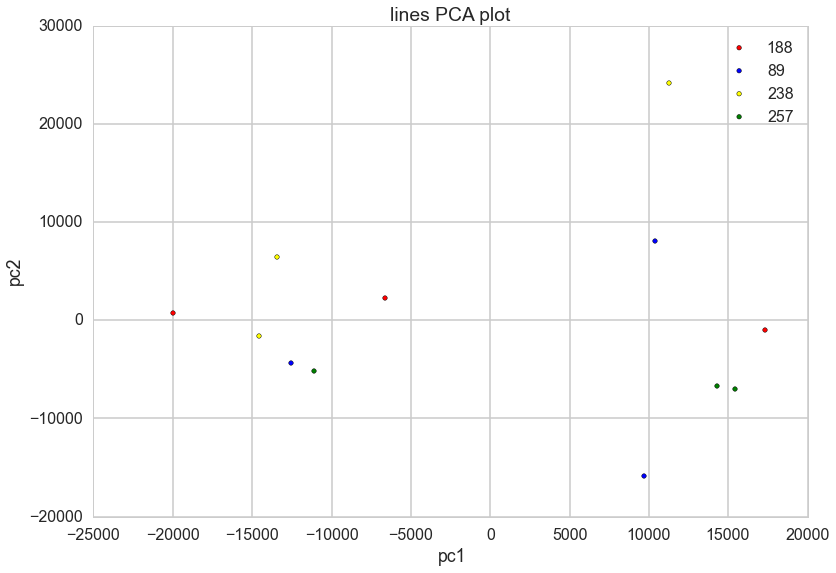

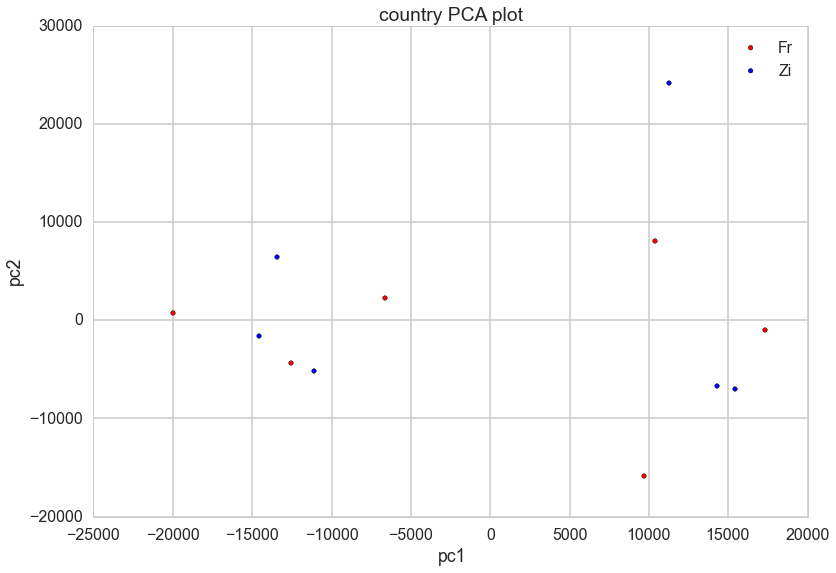

In [21]:
plot_PCA("lines",dfCarcassPCA)
plot_PCA("country", dfCarcassPCA)

##Now testes only data

In [22]:
dfT=LoadedData[[col for lab,col in zip(TorClabels,LoadedData.columns) if lab=="T"]]
pca = PCA(n_components=10)
X = pca.fit_transform(dfT.transpose())
pca.explained_variance_ratio_*100

array([ 48.96564559,  20.09377305,  16.77306748,   7.68853253,
         3.20153167,   1.05963619,   0.81770754,   0.55594556,
         0.39405091,   0.34155957])

In [23]:
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in dfT.columns]
countryLabels=[a[:2] for a in dfT.columns]
dfTPCA = pd.DataFrame({"lines":lineLabels, "country":countryLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfTPCA["pc%i" % (i+1)] = X[:,i]
dfTPCA

,country,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,Fr,188,-6542.961446,-1983.626235,1583.238387,3943.590330,-666.411919,-1723.432375,1690.185356,-1012.447862,3324.196426,-209.181931
1,Fr,188,19387.281470,-1482.963785,-3002.720429,-169.662785,-9569.096561,-2390.913611,-2156.447550,-1080.162828,-637.460698,1069.109207
2,Fr,89,4550.044795,598.210481,-6143.698970,-7398.207991,5716.714640,1875.432832,-4243.297572,-998.365365,102.887970,8.440905
3,Fr,89,12962.540226,-9494.560109,5683.824553,6963.249328,1986.478162,3385.722796,2422.111975,-1665.252069,-1699.305301,1342.313398
4,Fr,89,-12555.576114,5021.279006,961.381980,-10366.794270,1369.567885,-2694.742788,2434.470288,1594.360728,-1502.177285,1664.239028
5,Zi,238,12217.061049,-12436.305785,-21841.131671,-808.000812,1702.918005,-736.217155,1909.244360,925.471991,77.196520,-1286.450523
6,Zi,238,-26608.646156,4974.160081,-1464.385681,7502.563684,394.672369,-1962.830701,-796.151163,-1591.452878,-2120.822434,-1930.188096
7,Zi,238,-3925.074611,-10536.191228,7847.858552,7739.818197,740.761236,-200.647236,-2364.079843,4071.062340,116.142788,325.195538
8,Zi,257,-20086.825941,-14763.581565,9621.263394,-8993.966121,-2546.937139,1643.195412,-33.538172,-1192.369114,796.987994,-374.184949
9,Zi,257,-10084.748079,15191.621267,-8016.941912,5152.820598,1692.498643,932.801912,-326.874663,-375.964172,1252.090083,2207.607666


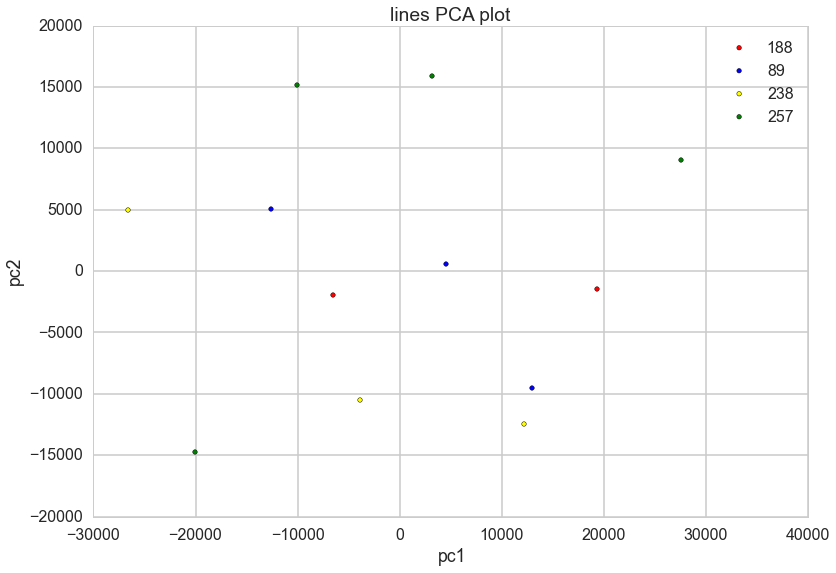

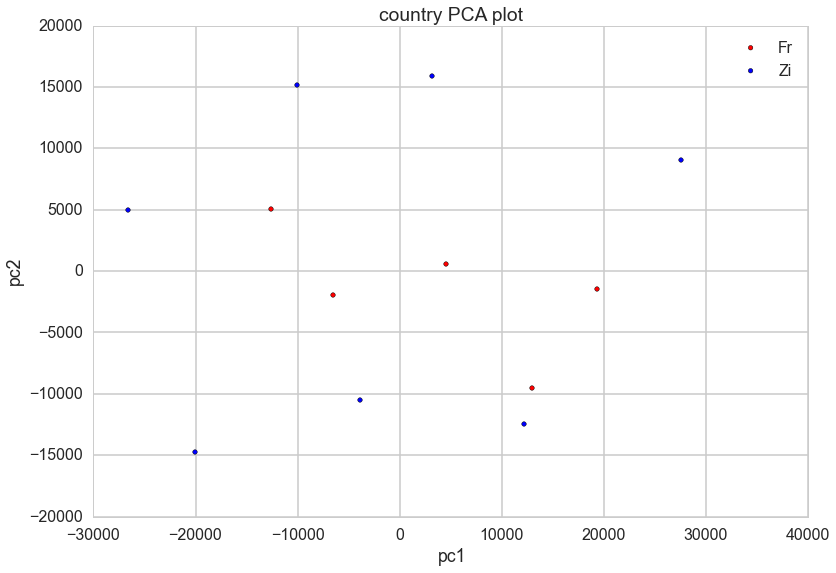

In [25]:
plot_PCA("lines",dfTPCA)
plot_PCA("country", dfTPCA)


###Plotting 2nd and 3rd component for testes data

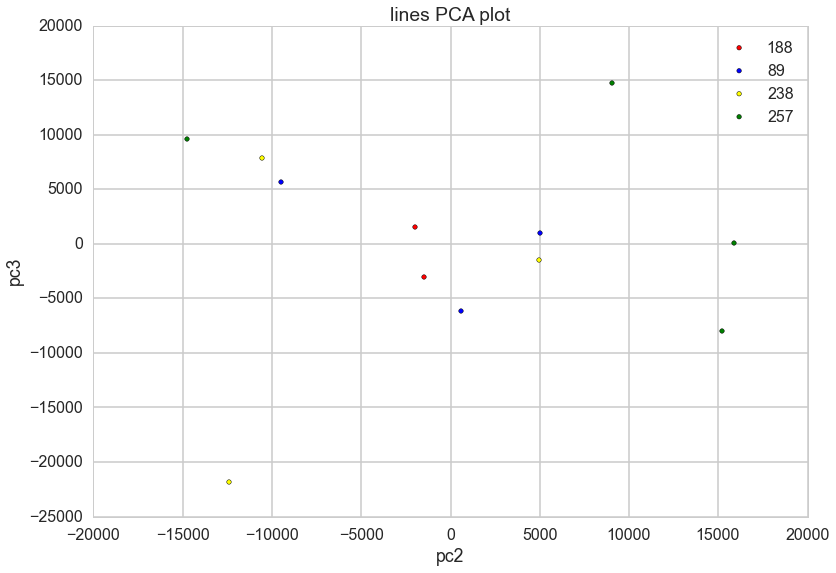

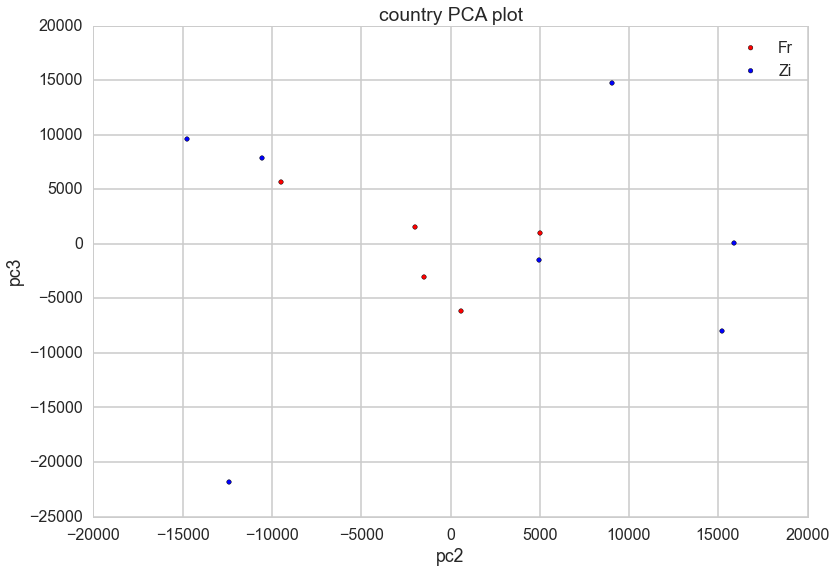

In [26]:
plot_PCA("lines",dfTPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("country", dfTPCA, firstComponent="pc2", secondComponent="pc3")